In [1]:
import numpy as np
import math
import pandas as pd
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit
from PIL import Image
import seaborn as sns; 
sns.set_style("whitegrid")

# %matplotlib notebook
# %matplotlib notebook
%matplotlib inline

In [2]:
drift_type = 'i' # i: incremental, a: abrupt, g: gradual
chunk_size = 1000

topics = ['RBFi-slow', 'RBFi-fast', "LED-4", 'RTGa', 'RTGa3', 'ARGWa-F1F4', 'ARGWa-F2F5F8', 'SEAa-F2F4', 'RTGg', 'RTGg3', 'ARGWg-F1F4', 'ARGWg-F2F5F8','SEAg-F2F4',  'ARGWa-F3F6F3F6', 'ARGWg-F3F6F3F6']

file_path = '../../DSClassificationResults/ConceptDriftExperimentsResults/{0}/'

data_file = {
# #     'ADLStream (CNN1 - 60x90)' : 'ADLStream_cnn1_60x90/data.csv',
# #     'ADLStream (CNN1 - 10x90)' : 'ADLStream_cnn1_10x90/data.csv',
# #     'ADLStream (CNN1 - 60x40)' : 'ADLStream_cnn1_60x40/data.csv',
# #     'ADLStream (CNN1 - 10x40)' : 'ADLStream_cnn1_10x40/data.csv',
#     'ADLStream (CNN2 - 60x90)' : 'ADLStream_cnn2_60x90/data.csv',
# #     'ADLStream (CNN2 - 10x90)' : 'ADLStream_cnn2_10x90/data.csv',
    'ADLStream' : 'ADLStream_cnn2_60x40/data.csv',
# #     'ADLStream (CNN2 - 10x40)' : 'ADLStream_cnn2_10x40/data.csv',
#     'ADLStream (MLP1 - 60x90)' : 'ADLStream_mlp1_60x90/data.csv',
# #     'ADLStream (MLP1 - 10x90)' : 'ADLStream_mlp1_10x90/data.csv',
#     'ADLStream (MLP1 - 60x40)' : 'ADLStream_mlp1_60x40/data.csv',
# #     'ADLStream (MLP1 - 10x40)' : 'ADLStream_mlp1_10x40/data.csv',
#     'ADLStream (MLP2 - 60x90)' : 'ADLStream_mlp2_60x90/data.csv',
# #     'ADLStream (MLP2 - 10x90)' : 'ADLStream_mlp2_10x90/data.csv',
#     'ADLStream (MLP2 - 60x40)' : 'ADLStream_mlp2_60x40/data.csv',
# #     'ADLStream (MLP2 - 10x40)' : 'ADLStream_mlp2_10x40/data.csv',
#     'ADLStream (MLP3 - 60x90)' : 'ADLStream_mlp3_60x90/data.csv',
# #     'ADLStream (MLP3 - 10x90)' : 'ADLStream_mlp3_10x90/data.csv',
#     'ADLStream (MLP3 - 60x40)' : 'ADLStream_mlp3_60x40/data.csv',
# #     'ADLStream (MLP3 - 10x40)' : 'ADLStream_mlp3_10x40/data.csv',
    'KUE' : 'MOA_KUE/data.csv',
    'ARF' : 'MOA_AdaptiveRandomForest/data.csv',
#     'AC' : 'MOA_ActiveClassifier/data.csv',
#     'NB' : 'MOA_NaiveBayes/data.csv',
#     'SCD' : 'MOA_SingleClassifierDrift/data.csv',
#     'MC' : 'MOA_MajorityClass/data.csv',
#     'P' : 'MOA_Perceptron/data.csv',
#     'SGD' : 'MOA_SGD/data.csv',
#     'SPEG' : 'MOA_SPegasos/data.csv',
#     'LevBag' : 'MOA_LeveragingBag/data.csv',
#     'OCBO' : 'MOA_OCBoost/data.csv',
#     'BA' : 'MOA_OzaBag/data.csv',
#     'B-ASHT' : 'MOA_OzaBagASHT/data.csv',
    'BA-AD' : 'MOA_OzaBagAdwin/data.csv',
#     'BO' : 'MOA_OzaBoost/data.csv',
#     'BO-AD' : 'MOA_OzaBoostAdwin/data.csv',
#     'WMC' : 'MOA_WeightedMajorityAlgorithm/data.csv',
#     'DST' : 'MOA_DecisionStump/data.csv',
#     'HOT' : 'MOA_HoeffdingOptionTree/data.csv',
#     'ADHOT' : 'MOA_AdaHoeffdingOptionTree/data.csv',
#     'HT' : 'MOA_HoeffdingTree/data.csv',
#     'ASHT' : 'MOA_ASHoeffdingTree/data.csv',
#     'HAT' : 'MOA_HoeffdingAdaptiveTree/data.csv',
#     'RHT' : 'MOA_RandomHoeffdingTree/data.csv'
}

figures_path = './files/drift/kappa/'

#pal = {True:[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)], False:[ '#5b1e20', '#943135', (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),'#d7878a', '#eac0c2']}
pal = {True:[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)], False:[ '#943135', (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),'#d7878a']}
styles = ['-','-','-', '-','-','--', ':', '-.', 'o-', 'x--', 's--', 'D--', 'v--', 'x--', 's--', 'D--', 'v--']

In [3]:
def read_result_csv(classifier, filepath):
    stream = pd.read_csv(filepath + data_file[classifier], 
                         header = None if 'MOA' in data_file[classifier] else 0, 
                         engine='c')
    return stream[stream.columns[-2:]]

data = { topic : { c : read_result_csv(c, file_path.format(topic))  for c in data_file } for topic in tqdm(topics) }
data[topics[0]][list(data_file.keys())[0]].sample(7)

100%|██████████| 15/15 [02:15<00:00,  9.04s/it]


,class,prediction
857893,1.0,1.0
231269,1.0,1.0
341276,1.0,1.0
364547,0.0,0.0
638407,2.0,2.0
109150,1.0,1.0
340000,2.0,2.0


In [4]:
def plot_classes_distribution(data_stream, w=10000):
    df_classes = pd.DataFrame()
    for c, d in data_stream.groupby('class')['class']:
        d = pd.Series([np.nan if i not in d.index else d[i] for i in data_stream.index])
        df_classes[c]=d.rolling(w, center=True).count()/w

    fig, ax = plt.subplots(figsize=(12,6))
    fig.suptitle('Classes distribution', fontsize=12)

    for c in df_classes.columns:
        ax.plot(df_classes[c][int(w/2):-int(w/2)], label='Class '+str(int(c)))
        
    ax.set_xlim(0, len(data_stream))
    ax.legend()
    fig.show()

#plot_classes_distribution(data[topics[0]][list(data_file.keys())[0]])

In [5]:
@jit(nopython=True)
def kappa(real, predicted):
    classes = np.unique(np.concatenate((real,predicted)))
    n_classes = len(classes)
    index_classes = np.full(n_classes, np.nan)
    for i,c in enumerate(classes):
        index_classes[int(c)] = i
        
    confusion_matrix = np.zeros((n_classes,n_classes))
    for i in np.arange(len(real)):
        confusion_matrix[int(index_classes[int(real[i])]), int(index_classes[int(predicted[i])])] += 1
        
    sum0 = np.sum(confusion_matrix, axis=0)
    sum1 = np.sum(confusion_matrix, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)
    
    w_mat = np.ones((n_classes, n_classes))
    for i in np.arange(n_classes):
        w_mat[i,i] = 0
    
    if np.sum(w_mat * expected) == 0:
        return 1
    k = np.sum(w_mat * confusion_matrix) / np.sum(w_mat * expected)
    
    return 1 - k

@jit
def prequential_eval_sequence_sliding(data, fading_factor=0.98, chunk_size=90, metric=kappa):
    data_clean =  data[:, -2:]
    current_metric = []
    for i in np.arange(chunk_size,data_clean.shape[0]):
        k = metric(data_clean[i-chunk_size :i,0], 
                   data_clean[i-chunk_size :i,1])
        k = k if not math.isnan(k)  else 1 
        
        if current_metric:
            k = (k + current_metric[-1]*fading_factor) / (1+fading_factor)
        current_metric.append(k)
    return current_metric[:]

@jit
def prequential_eval_sequence(data, fading_factor=0.98, chunk_size=90, metric=kappa):
    data_clean =  data[:, -2:]
    current_metric = []
    for i in range(0,data_clean.shape[0]+chunk_size, chunk_size):
        k = metric(data_clean[i:i+chunk_size,0], data_clean[i:i+chunk_size,1])
        k = 1 if math.isnan(k) else k
        if current_metric:
            k = (k + current_metric[-1]*fading_factor) / (1+fading_factor)
        current_metric.append(k)
    return current_metric[:]
    

In [6]:
def plot_drift_preq(title, data, x=None, sort=False, sort_key=np.mean, drift_type='i', drifts=[250000,500000,750000], drift_window=100000):
    fig, ax = plt.subplots(figsize=(8,7))

    text = fig.suptitle(title, fontsize=12)
    ax.set_ylabel('Kappa', fontsize='medium')
    ax.set_xlabel('Instances', fontsize='medium')
    ax.set_xlim((0,10**6))
    ax.set_ylim((
        np.floor(10*np.min(np.concatenate(list(data.values()))))/10,
        np.ceil(10*np.max(np.concatenate(list(data.values()))))/10
    ))
    
    if drift_type in ['g', 'a']: 
        for d in drifts:
            ax.axvline(x=d, c='r', alpha=0.5)
            if drift_type == 'g':
                ax.axvline(x=d-drift_window, c='r', alpha=0.5)
                ax.axvspan(d-drift_window, d, alpha=0.1, color='red')
    if sort:
        data_sort = {k: sort_key(data[k]) for k in data.keys() }
        data = {c:data[c] for c in sorted(data_sort, key=data_sort.get, reverse=True)}
    
    i = 0
    for c in data:
        k = data[c]
        clr = pal[c=='ADLStream'][i%len(pal[c=='ADLStream'])]
        stl = styles[i%len(styles)] if c!='ADLStream' else '-'
        i = i+1 if c!='ADLStream' else i
        if x is None or len(x)!=len(k):
            x = np.arange(0,chunk_size*len(k),chunk_size)
        ax.plot(x[:-1],  k[:-1], stl, label=(c + " (%0.1f)"% (sort_key(k)*100)) , c=clr)
        
#     ax.legend(bbox_to_anchor=(1., 1.))
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=4)
    fig.savefig(figures_path + title + '.png', bbox_extra_artists=(lgd,text), bbox_inches='tight', linewidth=0.8)
    return figures_path + title + '.png'

    

In [7]:

# l = len(list(data.values())[0])
data_kappa = {topic : {c : prequential_eval_sequence(data[topic][c].values[:], chunk_size=chunk_size) for c in data_file.keys()} for topic in tqdm(topics)}
# f = round(l/(len(list(data_kappa[topics[0]].values())[0])))
# x = [i*f +f for i in range(len(list(data_kappa[topics[0]][].values())[0]))]

100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


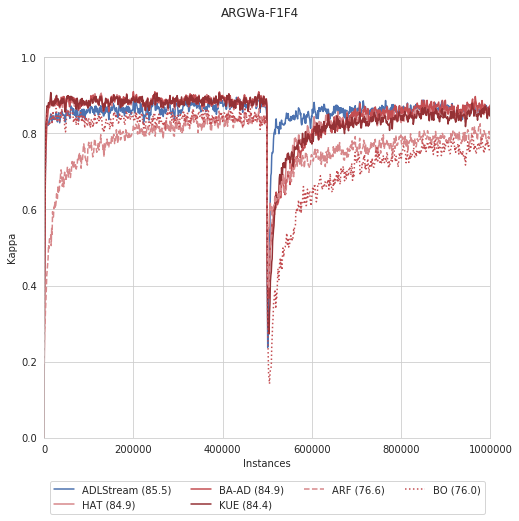

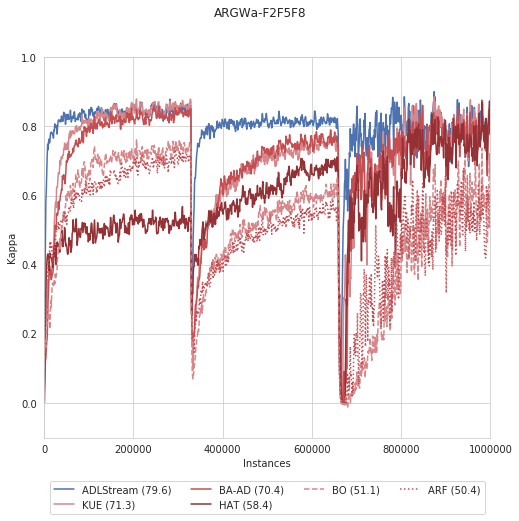

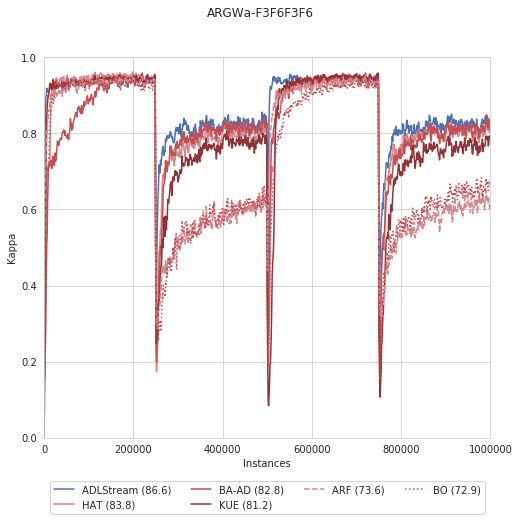

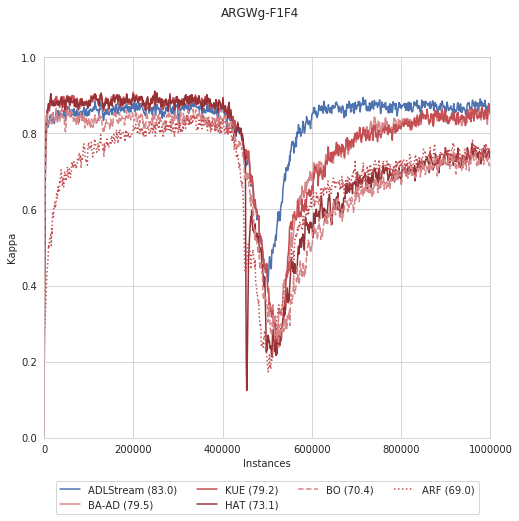

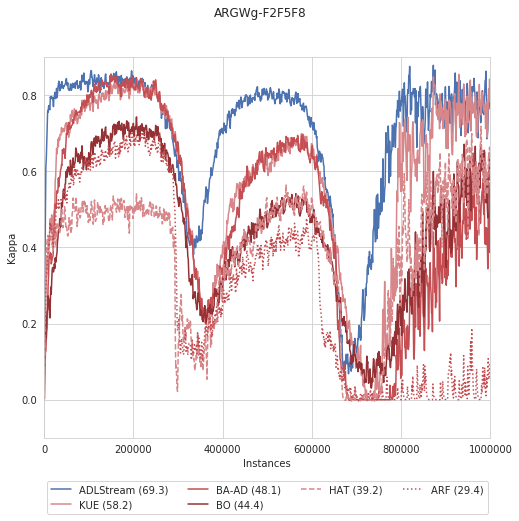

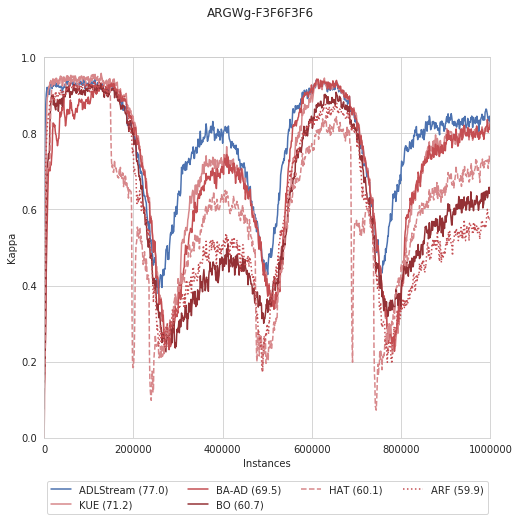

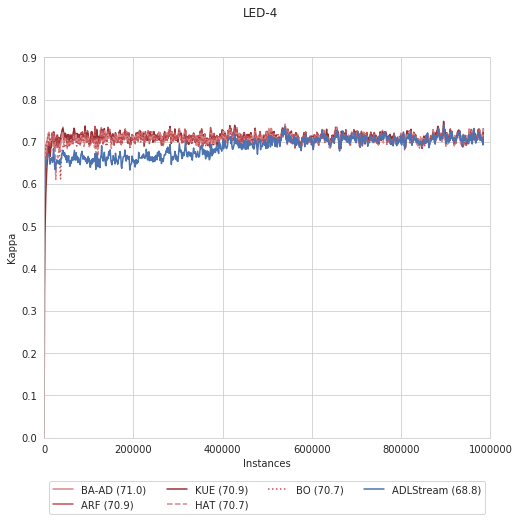

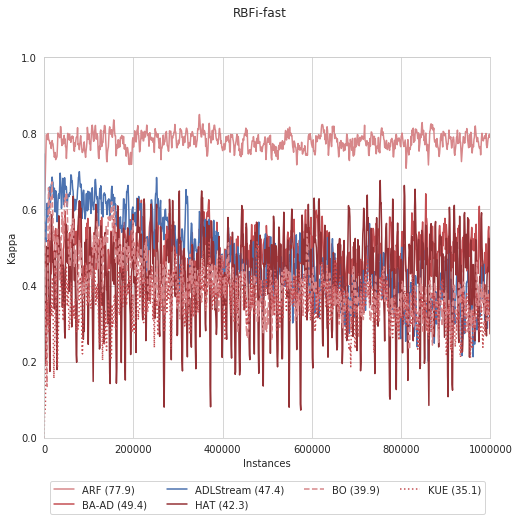

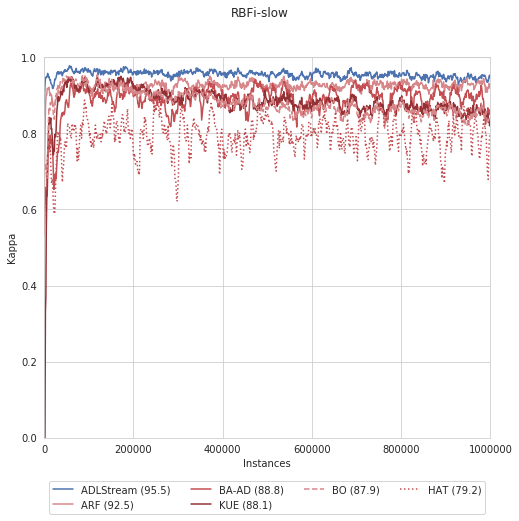

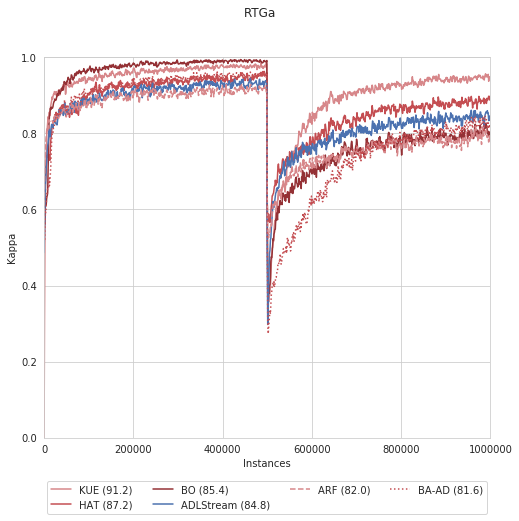

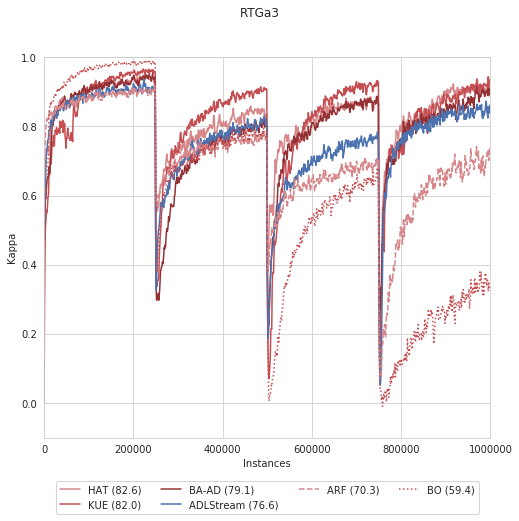

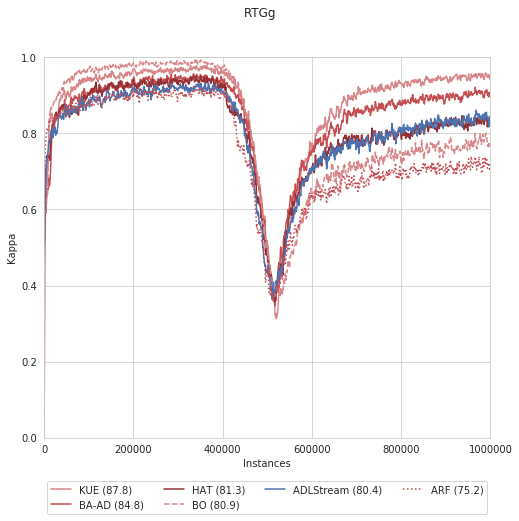

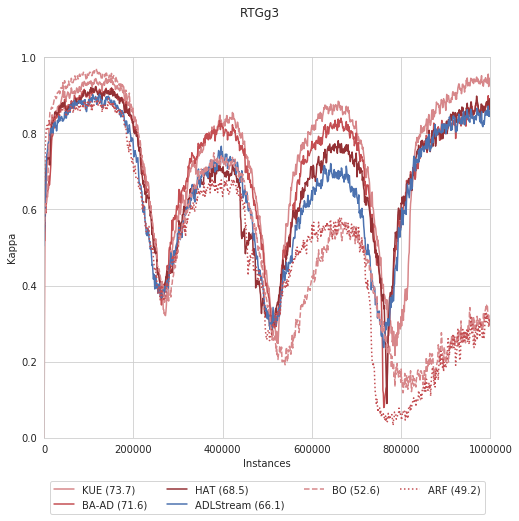

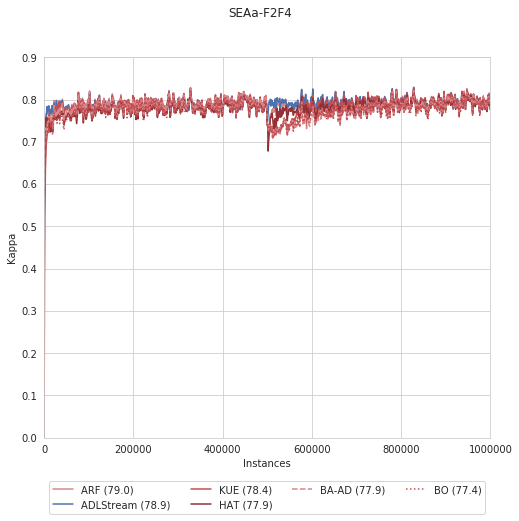

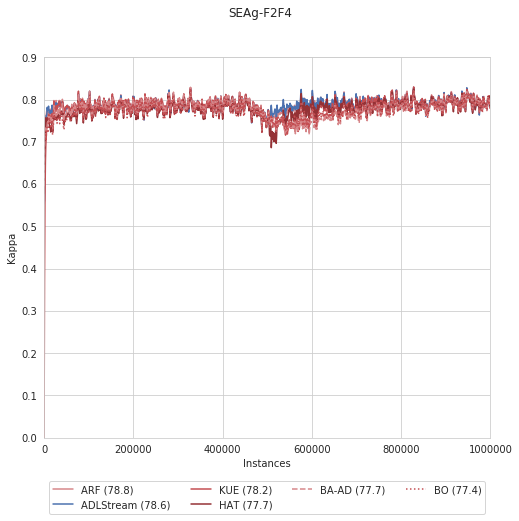

In [69]:
pdf_img_ls = []
for topic in sorted(topics):
    pdf_img_ls.append(plot_drift_preq(topic, data_kappa[topic], sort=True, sort_key=np.mean, drift_type='i'))

pdf_img_ls = [Image.open(i).convert('RGB') for i in pdf_img_ls]
pdf_filename = figures_path+'datastreams_drift_kappa_3.pdf'
first = pdf_img_ls[0].copy()
first.save(pdf_filename,"PDF", resolution=100.0, save_all=True, append_images=pdf_img_ls[1:])
pdf_img_ls = []

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


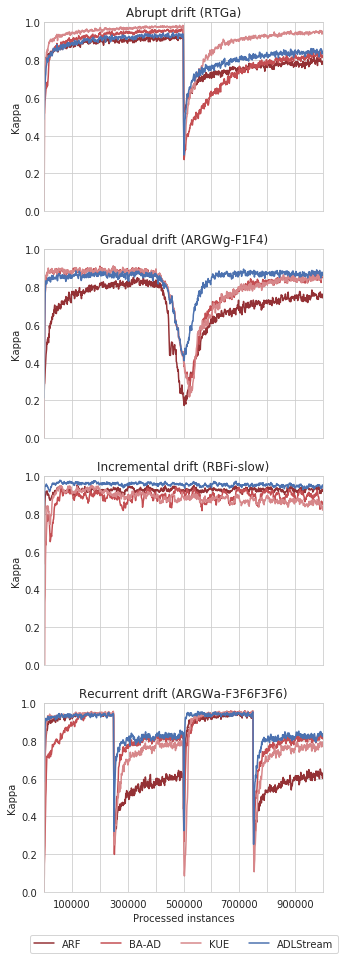

In [8]:
sample_topics = ['RTGa', 'ARGWg-F1F4', 'RBFi-slow', 'ARGWa-F3F6F3F6' ]
sample_titles = ['Abrupt drift', 'Gradual drift', 'Incremental drift', 'Recurrent drift' ]
classifiers = ['ARF', 'BA-AD', 'KUE', 'ADLStream']
fig, ax = plt.subplots(ncols=1,nrows=len(sample_topics), figsize=(5,4*len(sample_topics)))

#text = fig.suptitle(title, fontsize=12)

for i,topic in enumerate(sample_topics):
    ax[i].set_ylabel('Kappa', fontsize='medium')
    ax[i].set_xlim((0,10**6))
    ax[i].set_ylim((
        np.floor(10*np.min(np.concatenate(list(data_kappa[topic].values()))))/10,
        np.ceil(10*np.max(np.concatenate(list(data_kappa[topic].values()))))/10
    ))
    ax[i].set_title('{} ({})'.format(sample_titles[i], topic))
    x_ticks = np.arange(0,10**6+1,10**5)
    ax[i].set_xticks(x_ticks)
    
    
    j = 0
    for c in classifiers:#data_kappa[topic]:
        k = data_kappa[topic][c]
        clr = pal[c=='ADLStream'][j%len(pal[c=='ADLStream'])]
        stl = styles[j%len(styles)] if c!='ADLStream' else '-'
        x=None
        j = j+1 if c!='ADLStream' else j
        if x is None or len(x)!=len(k):
            x = np.arange(0,chunk_size*len(k),chunk_size)
        ax[i].plot(x[:-1],  k[:-1], stl, label=(c) , c=clr)

    #     ax.legend(bbox_to_anchor=(1., 1.))
    if i+1 == len(sample_topics):
        lgd = ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
        ax[i].set_xlabel('Processed instances', fontsize='medium')
        ax[i].set_xticklabels(['' if j%2==0 else x_ticks[j] for j in range(len(x_ticks))])
    else:
        ax[i].set_xticklabels([])
        ax[i].tick_params(axis=u'both', which=u'both',length=0)
        
fig.savefig(figures_path + 'drifts.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


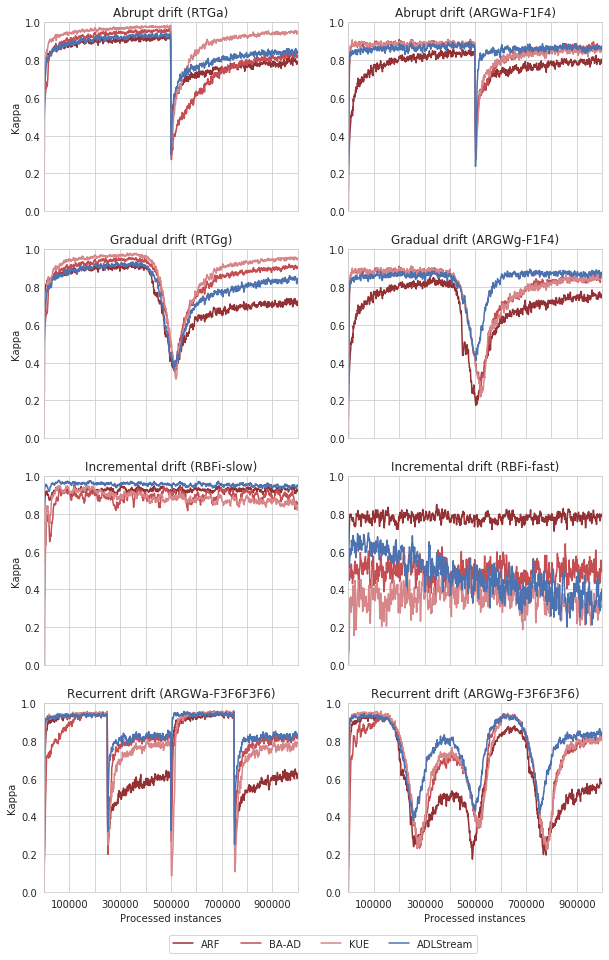

In [40]:
sample_topics = ['RTGa', 'ARGWa-F1F4', 'RTGg', 'ARGWg-F1F4', 'RBFi-slow', 'RBFi-fast', 'ARGWa-F3F6F3F6', 'ARGWg-F3F6F3F6' ]
sample_titles = ['Abrupt drift', 'Abrupt drift', 'Gradual drift', 'Gradual drift',
                 'Incremental drift', 'Incremental drift', 'Recurrent drift', 'Recurrent drift' ]
classifiers = ['ARF', 'BA-AD', 'KUE', 'ADLStream']
fig, ax = plt.subplots(ncols=2,nrows=int(len(sample_topics)/2), figsize=(5*2,4*len(sample_topics)/2))

#text = fig.suptitle(title, fontsize=12)

for index,topic in enumerate(sample_topics):
    i, j = int(index/2), index%2 
    
    if j==0:
        ax[i][j].set_ylabel('Kappa', fontsize='medium')
    ax[i][j].set_xlim((0,10**6))
    ax[i][j].set_ylim((
        np.floor(10*np.min(np.concatenate(list(data_kappa[topic].values()))))/10,
        np.ceil(10*np.max(np.concatenate(list(data_kappa[topic].values()))))/10
    ))
    ax[i][j].set_title('{} ({})'.format(sample_titles[index], topic))
    x_ticks = np.arange(0,10**6+1,10**5)
    ax[i][j].set_xticks(x_ticks)
    
    
    w = 0
    for c in classifiers:#data_kappa[topic]:
        k = data_kappa[topic][c]
        clr = pal[c=='ADLStream'][w%len(pal[c=='ADLStream'])]
        stl = styles[w%len(styles)] if c!='ADLStream' else '-'
        x=None
        w = w+1 if c!='ADLStream' else w
        if x is None or len(x)!=len(k):
            x = np.arange(0,chunk_size*len(k),chunk_size)
        ax[i][j].plot(x[:-1],  k[:-1], stl, label=(c) , c=clr)

    #     ax.legend(bbox_to_anchor=(1., 1.))
    if index+1 == len(sample_topics):
        lgd = ax[i][j].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.2), ncol=4)
    if (i+1)%(len(sample_topics)/2)==0:
        ax[i][j].set_xlabel('Processed instances', fontsize='medium')
        ax[i][j].set_xticklabels(['' if l%2==0 else x_ticks[l] for l in range(len(x_ticks))])
    else:
        ax[i][j].set_xticklabels([])
        ax[i][j].tick_params(axis=u'both', which=u'both',length=0)
        
fig.savefig(figures_path + 'drifts_8.eps', format='eps', bbox_inches='tight')
fig.savefig(figures_path + 'drifts_8.png', format='png', bbox_inches='tight')

In [12]:
plt.savefig('destination_path.eps', format='eps')

<Figure size 432x288 with 0 Axes>

In [92]:
from collections import defaultdict
kappa_table_dict = defaultdict(dict)
for topic in data_kappa.keys():
    for classifier in data_kappa[topic].keys():
        kappa_table_dict[topic][classifier] = np.mean(data_kappa[topic][classifier])

kappa_table = pd.DataFrame(kappa_table_dict).T.loc[topics]
kappa_table = kappa_table[sorted(kappa_table.columns, key=lambda c : -kappa_table.mean()[c])]
kappa_table.to_csv(figures_path+"results_table.csv")
kappa_table.head()

,ADLStream,KUE,BA-AD,HAT,ARF,BO
RBFi-slow,0.954885,0.881429,0.887698,0.792394,0.924917,0.879062
RBFi-fast,0.474429,0.351423,0.494499,0.422814,0.778799,0.399429
LED-4,0.687978,0.708537,0.709858,0.707416,0.709311,0.707299
RTGa,0.847538,0.912492,0.816027,0.871586,0.819663,0.853998
RTGa3,0.765757,0.820465,0.791214,0.826437,0.703472,0.594038


<BarContainer object of 6 artists>

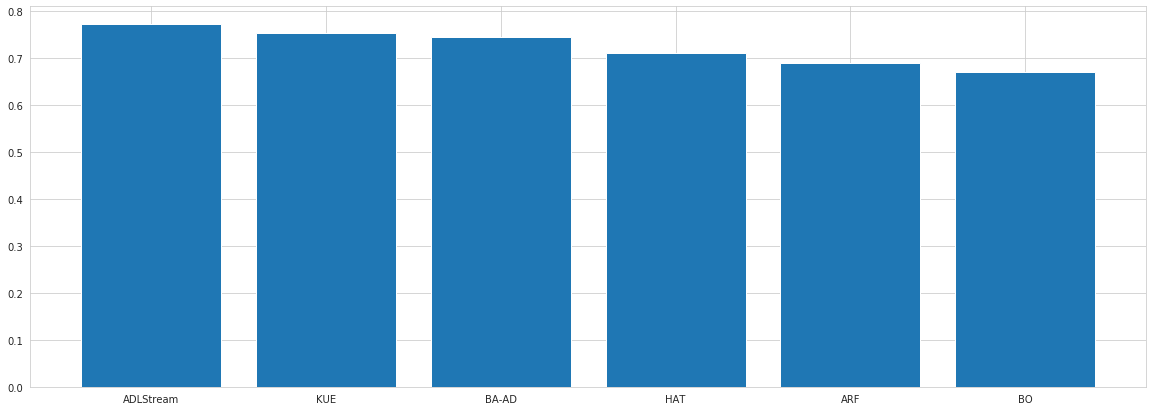

In [91]:
fig, ax = plt.subplots(figsize=(20,7))
ax.bar(x = kappa_table.columns , height=kappa_table.mean())